In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
from numpy import linalg as LA

In [0]:
#use Zhang's method to calculate H matrix
trans = []
#define the coordinates
image_point = np.array([[284.56243896,149.2925415],[373.93179321,128.26719666],[387.53588867,220.2270813],[281.29962158,241.72782898],[428.86453247,114.50731659],[524.76373291,92.09218597],[568.3659668, 180.55757141],[453.60995483,205.22370911]])
object_point = np.array([[0.0000,0.0000],[0.1315,0.0000],[0.1315, 0.1315],[0.0000, 0.1315],[0.2105, 0.0000],[0.3420, 0.0000],[0.3420, 0.1315],[0.2105, 0.1315]])

for i in range(8):
  x = object_point[i,0]
  y = object_point[i,1]
  u = image_point[i,0]
  v = image_point[i,1]
  #print (trans)
  #frame the DLT equations as matrix transforms
  trans.append([-x,-y,-1,0,0,0,u*x,u*y,u])
  trans.append([0,0,0,-x,-y,-1,v*x,v*y,v])
  

trans = np.array(trans)
#do SVD to solve least squares minimization problem
U,D,V = LA.svd(trans)
#last column gives params
L = V[-1:]


#reshape the column vector to a 3*3 homography
H = L.reshape(3,3)
#print (H.shape)
print ("Homography matrix:")
print (H)
world_point = np.array([[0.0000,0.0000,1],[0.1315,0.0000,1],[0.1315, 0.1315,1],[0.0000, 0.1315,1],[0.2105, 0.0000,1],[0.3420, 0.0000,1],[0.3420, 0.1315,1],[0.2105, 0.1315,1]])

#print (world_point.shape)
#project the points back to the image coordinates to determine the accuracy of our homography
transpose = world_point.T
points = np.dot(H,world_point.T)
#convert from Homogeneous coordinates
points=points/points[2,:]
print ("Reprojected points:")
print (points) 


Homography matrix:
[[ 6.80736673e-01 -3.91069979e-01  3.13988879e-01]
 [-2.00554997e-01  4.66643122e-01  1.64595846e-01]
 [-1.79175173e-04 -1.29795973e-03  1.10333906e-03]]
Reprojected points:
[[284.58058999 373.69341766 387.28596408 281.5215864  429.12370102
  524.7300731  568.49530203 453.50280852]
 [149.17975141 128.01050341 219.54389283 242.27484636 114.84273121
   92.13090561 180.59825604 205.31252263]
 [  1.           1.           1.           1.           1.
    1.           1.           1.        ]]


In [0]:
#given K matrix
K = [[406.952636, 0.000000, 366.184147], [0.000000, 405.671292, 244.705127],[ 0.000000, 0.000000, 1.000000]]
h = LA.inv(K).dot(H) 
h1 = np.array(h[:,0])
h2 = np.array(h[:,1])
h3 = np.array(h[:,2])
m3 = np.cross(h1,h2)        
M = np.vstack((h1, h2,m3)).T
M = np.array(M)
U,S,Vh = LA.svd(M)
#find R,t using the formula in description 
R = np.dot(U,Vh)
t = np.array(h3/(LA.norm(h1))).reshape(3,1)
print ("Rotation:")
print (R)
print ("Translation")
print (t)

Rotation:
[[ 0.97595478  0.10186357  0.19270726]
 [-0.19122635  0.82444202  0.5326611 ]
 [-0.10461721 -0.55670385  0.82409712]]
Translation
[[-0.11751003]
 [-0.13799209]
 [ 0.58601634]]


In [0]:
P = np.dot(K,np.hstack((R[:,0:2],t)))
transpose = world_point.T
points = np.dot(P,world_point.T)
#convert from Homogeneous coordinates
points=points/points[2,:]
print ("Reprojected points (with a certain error):")
print (points) 



Reprojected points:
[[284.58058999 373.88431411 385.93686547 283.56118512 429.6293024
  526.13373555 562.10733907 450.19981111]
 [149.17975141 129.0572678  200.22073887 221.3067187  116.49645217
   94.75145897 163.93548987 186.98471278]
 [  1.           1.           1.           1.           1.
    1.           1.           1.        ]]


Plotting the image with the reprojected points we have calculated (with a certain error)


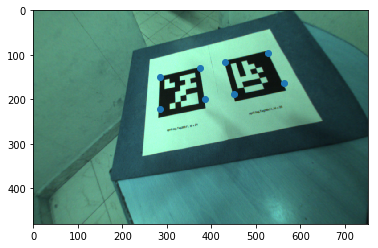

In [0]:
print ("Plotting the image with the reprojected points we have calculated (with a certain error)")
im=cv2.imread("image.png")
plt.scatter(points[0,:],points[1,:])
plt.imshow(im)
plt.show()

#Description
In this question, we need to find the homography using the given image points, and their corresponding world coordinates/object points. The image points are given to us in april_tags_info.txt. Now we need to define the world coordinates in order to do $Zhang's$ method (a 2D DLT) to find the homography matrix. By taking the bottom left corner of the left April Tag as the origin of the world coordinate system, and since we have been given the tag size and the distance between the tags, we can define the 8 world points as well. Normally we need only 4 points (which gives 8 correspondences) for a 2D-2D DLT, but in this case the 8 points gives a much more accurate homography.

We use the $DLT$ equations (after removing the z coordinates) to form the similarity relations, but we have to solve the least squares problem in order to remove redundant values, thus we use singular value decomposition to decompose the matrix. Now, the last column of this $n*n$ ($V^{T}$) matrix gives us the homography matrix as a vector, which we reshape as a matrix to get the required solution.

**Bonus**

Now that we have found the homography, we now need to decompose this matrix into $R,t$ (rotation and translation matrices). To do this, we must find $K^{1}H=$[h1 h2 h3]. But this might not be orthonormal, and to ensure this, we need to frame a minimization problem, such that our solution is closest to $M = [h1 ;h2 ;h1$x$h2]$. We do this by framing the minimization to be $argmin ||R-M||^{2}_{f}$. This gives $R =UV^{T}$ and $t=h3/||h1||$, and we use these relations to calculate rotation and translation. 

Using $R,t$ we can now calculate the reprojected points by using the homography given by $K [R t]$. The points give a certain reprojection error, and we have plotted these points and shown.